## Data preparation and data visualization

Contents:
    1. [Dataset loading and Cleansing](#1)
    2. Adding new Features
    3. Exploratory data analysis
    4. Independent t-test
    5. Affinity analysis using apriori and association rules
    6. Conclusion #6

<a id='1'> 
# 1. Dataset Loading and Cleansing</a>

In [21]:
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import re

In [22]:
purch_behav_data = pd.read_csv("../src/data/QVI_purchase_behaviour.csv")

In [23]:
qvi_tran_data = pd.read_excel("../src/data/QVI_transaction_data.xlsx")

In [24]:
def data_info(file):
    print("There are {} rows and {} columns.".format(file.shape[0], file.shape[1]), end = '\n')
    print("-------------head of the data------------------")
    print(file.head(5))
    print("-------------description of the data------------------")
    print(file.describe(include = "all"))
    print('-------------the number of null values-----------------')
    print(file.isna().sum())

### Based on this table, we can figure out that quantium customers mainly have<font color = 'red'> 7</font> different lifestage and <font color ="red">3 </font> types of customer segments. And customers who are in the lifestage of <span style="color:red">retirees</span>  or <span style="color:red">mainstream</span> customer segments have the highest number of consumption

In [25]:
data_info(purch_behav_data)

There are 72637 rows and 3 columns.
-------------head of the data------------------
   LYLTY_CARD_NBR               LIFESTAGE PREMIUM_CUSTOMER
0            1000   YOUNG SINGLES/COUPLES          Premium
1            1002   YOUNG SINGLES/COUPLES       Mainstream
2            1003          YOUNG FAMILIES           Budget
3            1004   OLDER SINGLES/COUPLES       Mainstream
4            1005  MIDAGE SINGLES/COUPLES       Mainstream
-------------description of the data------------------
        LYLTY_CARD_NBR LIFESTAGE PREMIUM_CUSTOMER
count     7.263700e+04     72637            72637
unique             NaN         7                3
top                NaN  RETIREES       Mainstream
freq               NaN     14805            29245
mean      1.361859e+05       NaN              NaN
std       8.989293e+04       NaN              NaN
min       1.000000e+03       NaN              NaN
25%       6.620200e+04       NaN              NaN
50%       1.340400e+05       NaN              NaN
75%    

Based on the followed tables, we can know the most popular product is <font color = "red"> Kettle Mozzarella   Basil & Pesto 175g </font> and it is bought by 3304 times. There are 114 kinds of products. For a single product the max number of quantity is <font color="red">200</font>. The average of PROD_QTY is 2 which means 200 is an outlier. The average total sales is <font color ="red">7.30</font> which means 650 would be an outlier.
For stores, the 226 number store has the highest shopping times and it is 2022.

In [28]:
qvi_tran_data[['STORE_NBR','PROD_NBR']] = qvi_tran_data[['STORE_NBR','PROD_NBR']].astype('category')
# After searching online, I got to know the date was starting from 1899-12-30.
# Convert them into standard DataTime format
qvi_tran_data[['DATE']] = pd.to_datetime(qvi_tran_data['DATE'],unit = 'D',origin=pd.Timestamp('1899-12-30'))

data_info(qvi_tran_data)

There are 264836 rows and 8 columns.
-------------head of the data------------------
        DATE STORE_NBR  LYLTY_CARD_NBR  TXN_ID PROD_NBR  \
0 2018-10-17         1            1000       1        5   
1 2019-05-14         1            1307     348       66   
2 2019-05-20         1            1343     383       61   
3 2018-08-17         2            2373     974       69   
4 2018-08-18         2            2426    1038      108   

                                  PROD_NAME  PROD_QTY  TOT_SALES  
0    Natural Chip        Compny SeaSalt175g         2        6.0  
1                  CCs Nacho Cheese    175g         3        6.3  
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9  
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0  
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8  
-------------description of the data------------------
                       DATE  STORE_NBR  LYLTY_CARD_NBR        TXN_ID  \
count                264836   2

In [29]:
# we only want to check out the prod are all chips, so we need to summarize the indicidual words in the product name.

prod_name_list = qvi_tran_data['PROD_NAME'].unique().tolist()
# Remove digits, and special characters


In [30]:
def prod_name_process(namelist):
    split_ch_dig=list(map(lambda x: [i for i in x.split(' ') if i != '' and re.search(r'[\W\d]',i) ==None ],prod_name_list))
    return reduce(lambda x,y: x +y,split_ch_dig)

In [31]:
#Let's look at the most common words by counting the number of times a word
# sorting them by this frequency in order of highest to lowest frequency
prod_name_list = prod_name_process(prod_name_list)
pd.Series(prod_name_list).value_counts()

Chips          21
Smiths         16
Crinkle        14
Cut            14
Kettle         13
               ..
Basil           1
Chimuchurri     1
Co              1
Crackers        1
Whlegrn         1
Length: 168, dtype: int64

In [32]:
# delete prod name containing salsa
new_df = qvi_tran_data.copy()
new_tran_df = new_df[new_df['PROD_NAME'].apply(lambda x:re.search(r'salsa',x.lower())==None)].reset_index(drop = True)

In [33]:
print("Total Transaction: "+str(qvi_tran_data.shape[0]))
print("Total Salsa Products: "+str(qvi_tran_data.shape[0]-new_tran_df.shape[0]))
print("Transactions without Salsa: "+str(new_tran_df.shape[0]))

Total Transaction: 264836
Total Salsa Products: 18094
Transactions without Salsa: 246742


In [34]:
new_tran_df.describe()

,index,LYLTY_CARD_NBR,TXN_ID,PROD_QTY,TOT_SALES
count,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000
mean,132435.326738,1.355310e+05,1.351311e+05,1.908062,7.321322
std,76465.593164,8.071528e+04,7.814772e+04,0.659831,3.077828
min,0.000000,1.000000e+03,1.000000e+00,1.000000,1.700000
25%,66269.250000,7.001500e+04,6.756925e+04,2.000000,5.800000
50%,132444.500000,1.303670e+05,1.351830e+05,2.000000,7.400000
75%,198626.750000,2.030840e+05,2.026538e+05,2.000000,8.800000
max,264835.000000,2.373711e+06,2.415841e+06,200.000000,650.000000


In [35]:
# in the new dataset the prod_qty and tot_sales has large outliers based on their separate mean 2, 5.8.

In [36]:
# product quantity appears to have an outlier which we should investigate further.
# where 200 packets of chips are bought in one transaction.
new_tran_df[new_tran_df['PROD_QTY']==200]


,index,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
64955,69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
64956,69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


### These two transactions were made by the same customer at the same store.

In [37]:
# Let we check out this customer's other transactions
new_tran_df[new_tran_df['LYLTY_CARD_NBR']==226000]

,index,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
64955,69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
64956,69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


### It looks like this customer has only had the two transactions over the year and is not an ordinary retail customer. 

In [38]:
idx_name = new_tran_df[new_tran_df['LYLTY_CARD_NBR']==226000].index
new_tran_df.drop(idx_name, inplace =True)
#check again
new_tran_df[new_tran_df['LYLTY_CARD_NBR']==226000]

,index,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES


In [39]:
# re-examine transaction data
new_tran_df.describe()

,index,LYLTY_CARD_NBR,TXN_ID,PROD_QTY,TOT_SALES
count,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000
mean,132435.834745,1.355303e+05,1.351304e+05,1.906456,7.316113
std,76465.694879,8.071520e+04,7.814760e+04,0.342499,2.474897
min,0.000000,1.000000e+03,1.000000e+00,1.000000,1.700000
25%,66268.750000,7.001500e+04,6.756875e+04,2.000000,5.800000
50%,132445.500000,1.303670e+05,1.351815e+05,2.000000,7.400000
75%,198627.250000,2.030832e+05,2.026522e+05,2.000000,8.800000
max,264835.000000,2.373711e+06,2.415841e+06,5.000000,29.500000


In [42]:
num_of_purch_per_day = new_tran_df.groupby('DATE')['DATE'].count().reset_index(name='Count')

In [45]:
num_of_purch_per_day.shape

(364, 2)

### There are only 364 days which means missing one day's number of purchase, we need to find out which day it is. 

In [49]:
year = set(pd.date_range(start ='2018-07-01', end = '2019-06-30'))

In [50]:
year - set(num_of_purch_per_day['DATE'])

{Timestamp('2018-12-25 00:00:00', freq='D')}

### With that we get to know we are missing the purchases of '2018-12-25'

Text(0.5, 1.0, 'Number of Purchase per day')

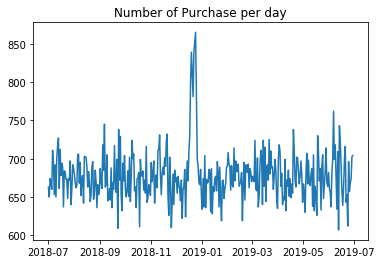

In [43]:
plt.plot(num_of_purch_per_day['DATE'], num_of_purch_per_day['Count'])
plt.title('Number of Purchase per day')

### From the chart we can see there is an increase in purchases in December and a break in late December.

(array([737029., 737033., 737037., 737041., 737045., 737049., 737053.,
        737057., 737060.]),
 <a list of 9 Text xticklabel objects>)

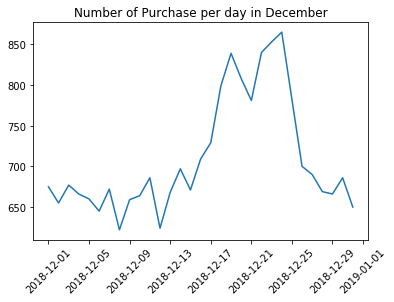

In [65]:
# take a close look at December's transactions
dec_trans = num_of_purch_per_day[(num_of_purch_per_day.DATE.dt.month ==12) & (num_of_purch_per_day.DATE.dt.year==2018)]
plt.plot(dec_trans.DATE, dec_trans.Count)
plt.title('Number of Purchase per day in December')
plt.xticks(rotation = 45)

### we can see that the increase was during Christmas. Now that we can move to other features such as pack size or brands. 

In [93]:
# pack size
new_tran_df['PROD_SIZE']=new_tran_df['PROD_NAME'].apply(lambda x: re.findall(r'\d+',x))
# to check whether have more than one numbers in the PROD_size
new_tran_df[new_tran_df.PROD_SIZE.str.len() >1]

,index,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_SIZE


In [96]:
# then we like to get rid of the list parathesis
new_tran_df['PROD_SIZE'] = new_tran_df['PROD_SIZE'].apply(lambda x: x[0]).astype('int')

In [98]:
# get the prodsize summary
new_tran_df['PROD_SIZE'].describe()

count    246740.000000
mean        175.583521
std          59.432118
min          70.000000
25%         150.000000
50%         170.000000
75%         175.000000
max         380.000000
Name: PROD_SIZE, dtype: float64

### The largest size is 380g and the smallest size is 70g

(array([  4515.,  23841.,  71532., 106133.,  12309.,   3169.,   6285.,
             0.,  12540.,   6416.]),
 array([ 70., 101., 132., 163., 194., 225., 256., 287., 318., 349., 380.]),
 <a list of 10 Patch objects>)

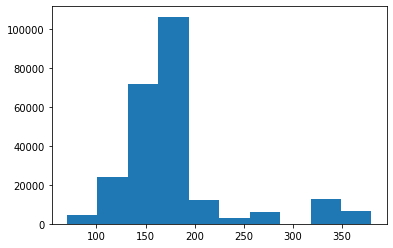

In [139]:
# prod size distribution
plt.hist(new_tran_df['PROD_SIZE'])

In [140]:
# get brand names
new_tran_df.head()

,index,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_SIZE
0,0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175
1,1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175
2,2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170
3,3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175
4,4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150


### Some of the brand names look like they are of the same brands - such as RED and
RRD, which are both Red Rock Deli chips. Let's combine these together.

In [145]:
new_tran_df['PROD_NAME'].apply(lambda x: x.split(' ')[0]).unique()


array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

In [148]:
new_tran_df['Brand'] = new_tran_df['PROD_NAME'].apply(lambda x: x.split(' ')[0])

In [151]:
# we can see Dorito equals to Doritos, Red = RRD, Infuzions = Infzns, Smiths = Smith
d = {'red':'RRD','ww':'WOOLWORTHS','ncc':'NATURAL','snbts':'SUNBITES','infzns':'INFUZIONS','smith':'SMITHS','dorito':'DORITOS','grain':'GRNWVES'}


In [156]:
new_tran_df['Brand'] = new_tran_df['Brand'].str.lower().replace(d).str.capitalize()
new_tran_df.head()

,index,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_SIZE,Brand
0,0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural
1,1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,Ccs
2,2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths
3,3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths
4,4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle


### Noe we are going to take a look at the customer dataset

In [158]:
purch_behav_data.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [161]:
merged_data = pd.merge(new_tran_df, purch_behav_data, how = 'left', on ='LYLTY_CARD_NBR')

In [164]:
new_tran_df.shape, purch_behav_data.shape,merged_data.shape

((246740, 11), (72637, 3), (246740, 13))

In [162]:
#so there is no duplicate create.
merged_data.head()

,index,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_SIZE,Brand,LIFESTAGE,PREMIUM_CUSTOMER
0,0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural,YOUNG SINGLES/COUPLES,Premium
1,1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,Ccs,MIDAGE SINGLES/COUPLES,Budget
2,2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths,MIDAGE SINGLES/COUPLES,Budget
3,3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths,MIDAGE SINGLES/COUPLES,Budget
4,4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle,MIDAGE SINGLES/COUPLES,Budget


In [166]:
# checking for null customers and whether any transactions did not have a matched customer
merged_data.isna().sum()

index               0
DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PROD_SIZE           0
Brand               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [167]:
merged_data.to_csv('merged_data.csv')

In [361]:
outliers.head()

,index,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
3,3,1899-12-30 00:00:00.000043329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
10,11,1899-12-30 00:00:00.000043332,8,8294,8221,114,Kettle Sensations Siracha Lime 150g,5,23.0
15,16,1899-12-30 00:00:00.000043330,20,20418,17413,94,Burger Rings 220g,4,9.2
29,31,1899-12-30 00:00:00.000043600,43,43227,40186,26,Pringles Sweet&Spcy BBQ 134g,4,14.8
52,56,1899-12-30 00:00:00.000043601,74,74336,73182,84,GrnWves Plus Btroot & Chilli Jam 180g,5,15.5


In [364]:
tran_df_no.describe()

,index,LYLTY_CARD_NBR,TXN_ID,PROD_QTY,TOT_SALES
count,245954.000000,2.459540e+05,2.459540e+05,245954.000000,245954.000000
mean,132469.091501,1.355366e+05,1.351361e+05,1.898079,7.285913
std,76468.987856,8.073068e+04,7.815137e+04,0.307980,2.402695
min,0.000000,1.000000e+03,1.000000e+00,1.000000,1.700000
25%,66287.250000,7.001500e+04,6.756625e+04,2.000000,5.800000
50%,132473.500000,1.303700e+05,1.352005e+05,2.000000,7.400000
75%,198645.750000,2.030860e+05,2.026658e+05,2.000000,8.800000
max,264835.000000,2.373711e+06,2.415841e+06,3.000000,19.500000


In [349]:
new_tran_df['PROD_QTY']>=qty_lower 

0         True
1         True
2         True
3         True
4         True
          ... 
246737    True
246738    True
246739    True
246740    True
246741    True
Name: PROD_QTY, Length: 246742, dtype: bool

In [344]:
new_tran_df.describe()['PROD_QTY']['std']

0.6598311218596009

In [122]:
lifestages = purch_behav_data['LIFESTAGE'].unique()
print("The 7 lifestages are:", lifestages)

The 7 lifestages are: ['YOUNG SINGLES/COUPLES' 'YOUNG FAMILIES' 'OLDER SINGLES/COUPLES'
 'MIDAGE SINGLES/COUPLES' 'NEW FAMILIES' 'OLDER FAMILIES' 'RETIREES']


In [129]:
qvi_tran_data[qvi_tran_data["STORE_NBR"]==226].count()

DATE              2022
STORE_NBR         2022
LYLTY_CARD_NBR    2022
TXN_ID            2022
PROD_NBR          2022
PROD_NAME         2022
PROD_QTY          2022
TOT_SALES         2022
dtype: int64

In [7]:
prem_cust = purch_behav_data['PREMIUM_CUSTOMER'].unique()

In [8]:
print('The 3 different premium customers are:',prem_cust)

The 3 different premium customers are: ['Premium' 'Mainstream' 'Budget']


In [9]:
purch_behav_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [31]:
lifestage =purch_behav_data['LIFESTAGE'].value_counts()

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

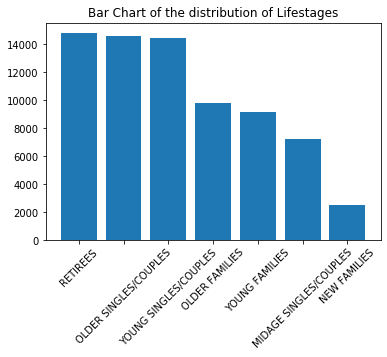

In [42]:
plt.bar(lifestage.index, lifestage )
plt.title("Bar Chart of the distribution of Lifestages")
plt.xticks(rotation = 45)

In [21]:
cust_segs = purch_behav_data['PREMIUM_CUSTOMER'].value_counts()

NameError: name 'data' is not defined